In [1]:
'''
python /home/hsher/projects/oligoCLIP/scripts/analyze_betabinom_mixture_most_enriched.py \
    /home/hsher/scratch/oligo_PE_iter4/internal_output/DMN \
    Rep2.PRPF8 \
    /home/hsher/scratch/oligo_PE_iter4/internal_output/counts/genome/bgtables/internal/iter4.PRPF8.tsv.gz \
    /projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz

python /home/hsher/projects/oligoCLIP/scripts/analyze_betabinom_mixture_most_enriched.py \
    /home/hsher/scratch/oligo_PE_iter4/internal_output/DMN \
    Rep2.FXR2 \
    /home/hsher/scratch/oligo_PE_iter4/internal_output/counts/genome/bgtables/internal/iter4.FXR2.tsv.gz \
    /projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz

python /home/hsher/projects/oligoCLIP/scripts/analyze_betabinom_mixture_most_enriched.py \
    /home/hsher/scratch/ABC_2rep/beta-mixture_CC \
    K562_rep4.PRPF8 \
    /home/hsher/scratch/ABC_2rep/counts_CC/genome/bgtables/internal/K562.PRPF8.tsv.gz \
    /projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz
'''
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats

from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import betabinom
from plot_params import *



In [2]:
basedir=Path('/home/hsher/scratch/ABC_singleplex_SLBP/')

In [3]:
def is_goldstandard(row):
    return ('UTR3' in row['feature_types'] or 'CDS_STOP' in row['feature_types']) and (
        row['gene_name'].startswith('H1') or row['gene_name'].startswith('H2') or
        row['gene_name'].startswith('H3') or row['gene_name'].startswith('H4'))
        

In [4]:
# find all files
beta_external = list(basedir.glob('beta-mixture_external/*/*window_score.tsv'))

In [5]:
cdict = dict(zip(['oligoCLIP_ctrlSpike_rep1', 'oligoCLIP_ctrlSpike_rep2',
       'oligoCLIP_ctrlBead_rep1', 'oligoCLIP_ctrlBead_rep2',
                  'oligoCLIP_IgG_rep2','oligoCLIP_IgG_rep1',
       'eCLIP_SLBP_SMInput', 'ABC_K562_summed'
       , 'K562_totalRNAseq'],
        
                 ['tomato', 'red',
                  'gold', 'orange', 
                  'seagreen', 'limegreen',
                  'grey', 
                  'orchid', 
                  'royalblue']
                ))

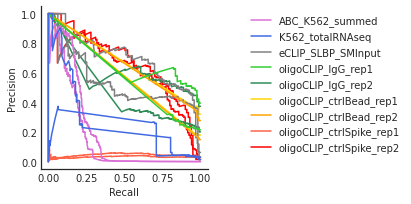

In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from collections import OrderedDict
stat = []
cnts = []
f, ax = plt.subplots(1,1, figsize = (3,3))
for file in beta_external:
    rep = file.name.split('.')[0]
    ctrl = file.parent.name
    
    df = pd.read_csv(file, sep = '\t')
    df['is_histone']=df.apply(is_goldstandard, axis = 1)
    try:
        df['composite_score']=(-np.log(df['pvalue']+1e-5)).fillna(0)+df['logLR'].fillna(0)
    except:
        df['composite_score']=(-np.log(df['pvalue']+1e-5)).fillna(0)
    
    df['composite_score'] = df['composite_score'].replace(-np.inf, -100)
    
    # both
    precision, recall, thresholds = precision_recall_curve(df['is_histone'], 
                                                        df['composite_score'])

    auprc = auc(recall, precision)
    ax.plot(recall, precision, label = f'{ctrl}',color = cdict[ctrl])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    stat.append([rep, ctrl, auprc])
    
#     # logLR
#     try:
#         precision, recall, thresholds = precision_recall_curve(df.loc[~df['logLR'].isnull(), 'is_histone'], 
#                                                             df.loc[~df['logLR'].isnull(), 'logLR'])

#         auprc = auc(recall, precision)
#         ax[1].plot(recall, precision, label = f'{ctrl}(AUPRC={auprc:.2f})', color = cdict[ctrl])
#     except:
#         pass
    
#     # pval
#     try:
#         precision, recall, thresholds = precision_recall_curve(df.loc[~df['pvalue'].isnull(), 'is_histone'], 
#                                                             1-df.loc[~df['pvalue'].isnull(), 'pvalue'])

#         auprc = auc(recall, precision)
#         ax[2].plot(recall, precision, label = f'{ctrl}(AUPRC={auprc:.2f})',color = cdict[ctrl])
#     except:
#         pass
    
    
    
    
    pivot = df.groupby(by = ['enriched', 'is_histone']).count()['name']
    pivot.name = ctrl+'.'+rep
    cnts.append(pivot)

sns.despine()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(sorted(zip(labels, handles), key=lambda x: x[0]))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.2, 1))

cnts=pd.concat(cnts,axis = 1).fillna(0)
plt.savefig(figdir/'AUPRC_beta_SLBPsingleplex.pdf')

In [7]:
def cnt_to_f1(cnts):
    precision_at_cutoff = (cnts.loc[True, True]/(cnts.loc[True, True]+cnts.loc[True, False]))
    recall_at_cutoff = (cnts.loc[True, True]/(cnts.loc[True, True]+cnts.loc[False, True]))
    id_ = pd.Series(precision_at_cutoff.index).str.split('.', expand = True)
    id_.index = precision_at_cutoff.index
    pr_cutoff = pd.concat([precision_at_cutoff, recall_at_cutoff, id_], axis = 1)
    pr_cutoff.columns = ['Precision', 'Recall','ctrl', 'lib']
    pr_cutoff['F1'] = 2 * (precision_at_cutoff * recall_at_cutoff) / (precision_at_cutoff + recall_at_cutoff)
    pr_cutoff['ctrl_type']=pr_cutoff['ctrl'].str.split('_rep', expand = True)[0]
    return pr_cutoff

In [8]:
pr_cutoff = cnt_to_f1(cnts)

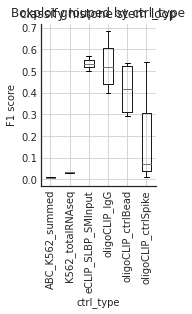

In [9]:
pr_cutoff.boxplot(by = 'ctrl_type', column = ['F1'], rot = 90, figsize = (2,3))

plt.ylabel('F1 score')
plt.title('classify histone stem loop')
sns.despine()
plt.savefig(figdir/'F1_beta_SLBPsingleplex.pdf')

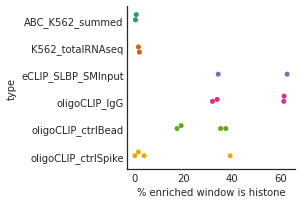

In [25]:

f, ax = plt.subplots(1,1,figsize = (3,3), sharey = True)


perc_histone = (cnts.loc[True, True]/(cnts.loc[True, True]+cnts.loc[True, False])).to_frame()*100
perc_histone['type'] = [i.split('_rep')[0] for i in pd.Series(perc_histone.index).str.split('.', expand = True)[0].tolist()]
sns.swarmplot(data=perc_histone.sort_index(), x = 0, y = 'type', ax = ax)

ax.set_xlabel('% enriched window is histone')
sns.despine()


plt.savefig(figdir/'SLBP_singleplex_perc_histone.pdf')

In [30]:
from scipy.stats import ttest_ind
ttest_ind(pr_cutoff.loc[pr_cutoff['ctrl_type']=='K562_totalRNAseq', 'F1'],
         pr_cutoff.loc[pr_cutoff['ctrl_type']=='ABC_K562_summed', 'F1']
        )

Ttest_indResult(statistic=4.867946278804404, pvalue=0.0397033775066445)

In [31]:
from scipy.stats import ttest_ind
ttest_ind(pr_cutoff.loc[pr_cutoff['ctrl_type']=='K562_totalRNAseq', 'F1'],
         pr_cutoff.loc[pr_cutoff['ctrl_type']=='eCLIP_SLBP_SMInput', 'F1']
        )

Ttest_indResult(statistic=-14.378217839421831, pvalue=0.004802337130040791)

In [33]:
from scipy.stats import ttest_ind
ttest_ind(pr_cutoff.loc[pr_cutoff['ctrl_type']=='oligoCLIP_IgG', 'F1'],
         pr_cutoff.loc[pr_cutoff['ctrl_type']=='eCLIP_SLBP_SMInput', 'F1']
        )


Ttest_indResult(statistic=-0.05191800904732026, pvalue=0.9610833439941635)

In [35]:
from scipy.stats import ttest_ind
ttest_ind(pr_cutoff.loc[pr_cutoff['ctrl_type']=='oligoCLIP_ctrlBead', 'F1'],
         pr_cutoff.loc[pr_cutoff['ctrl_type']=='eCLIP_SLBP_SMInput', 'F1']
        )


Ttest_indResult(statistic=-1.1982288976517794, pvalue=0.2969678205242271)

In [37]:
pr_cutoff.loc[pr_cutoff['ctrl_type']=='oligoCLIP_ctrlSpike', 'F1']

oligoCLIP_ctrlSpike_rep1.K562_SLBP_rep1    0.010152
oligoCLIP_ctrlSpike_rep1.K562_SLBP_rep2         NaN
oligoCLIP_ctrlSpike_rep2.K562_SLBP_rep2    0.070938
oligoCLIP_ctrlSpike_rep2.K562_SLBP_rep1    0.543590
Name: F1, dtype: float64

In [38]:
from scipy.stats import ttest_ind
ttest_ind(pr_cutoff.loc[pr_cutoff['ctrl_type']=='oligoCLIP_ctrlSpike', 'F1'].dropna(),
         pr_cutoff.loc[pr_cutoff['ctrl_type']=='eCLIP_SLBP_SMInput', 'F1']
        )

Ttest_indResult(statistic=-1.4840081498506759, pvalue=0.23445773267060022)

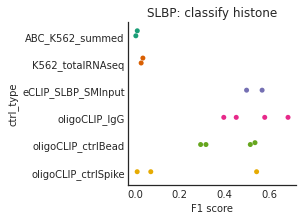

In [29]:
f, ax = plt.subplots(1,1, figsize = (3,3), sharey = True)
sns.swarmplot(data = pr_cutoff.sort_index(), y = 'ctrl_type', x = 'F1',  ax=ax)
#sns.swarmplot(data = pr_cutoff_eclip.sort_index(), y = 'ctrl_type', x = 'F1',  ax=ax[1])
ax.set_xlabel('F1 score')
ax.set_title('SLBP: classify histone')
#ax[1].set_title('classify RBFOX2 eCLIP sites')
sns.despine()
plt.savefig(figdir/'F1_beta_SLBPsingleplex.pdf')

<AxesSubplot: >

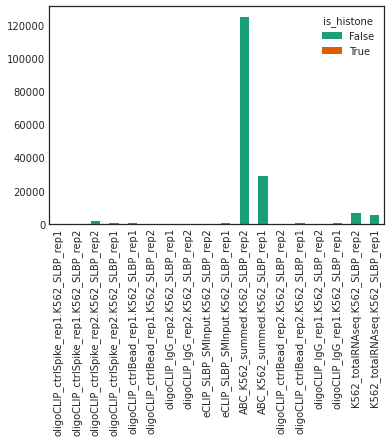

In [11]:
cnts_id = cnts.reset_index()
cnts_id = cnts_id.loc[cnts_id['enriched']].set_index('is_histone').T
cnts_id.drop('enriched').plot.bar(stacked = True)

In [12]:
stat = pd.DataFrame(stat, columns = ['rep', 'ctrl', 'AUPRC'])

In [13]:
skipper_external = list(basedir.glob('skipper_external/*/tested_windows/*.tested_windows.tsv.gz'))
window_df = pd.read_csv('/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz', sep = '\t')

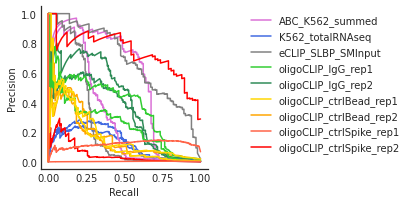

In [ ]:
stat_skipper=[]
skipper_cnts = []


f, ax = plt.subplots(figsize = (3,3))
for f in skipper_external:
    rep = f.name.split('.')[0]
    ctrl = f.parent.parent.name
    df = pd.read_csv(f, sep = '\t')
    df['feature_types']=df['name'].map(window_df.set_index('name')['feature_types'])
    df['gene_name']=df['name'].map(window_df.set_index('name')['gene_name'])      
    iteration = str(f).split('/')[4]
    background = 'CC' if 'CC' in str(f) else 'IgG'
    exp = f.name.split('.')[0]
    if df.shape[0]>0:
        
        
        df['pvalue'].fillna(1)
        df['is_histone'] = df.apply(is_goldstandard, axis = 1)
        precision, recall, thresholds = precision_recall_curve(df['is_histone'], 
                                                        -df['pvalue'])

        auprc = auc(recall, precision)
        ax.plot(recall, precision, label = f'{ctrl}', color = cdict[ctrl])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        stat_skipper.append([rep, ctrl, auprc])
        
        df['enriched']=df['qvalue'].le(0.2)
        pivot = df.groupby(by = ['enriched', 'is_histone']).count()['name']
        pivot.name = ctrl+'.'+rep
        skipper_cnts.append(pivot)
sns.despine()
stat_skipper = pd.DataFrame(stat_skipper, columns = ['rep', 'ctrl', 'AUPRC'])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(sorted(zip(labels, handles), key=lambda x: x[0]))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.2, 1))

In [ ]:
skipper_cnts=pd.concat(skipper_cnts,axis = 1).fillna(0)
pr_cutoff_skipper = cnt_to_f1(skipper_cnts).fillna(0)

In [ ]:
figdir

PosixPath('/home/hsher/scratch/mudskipper_fig')

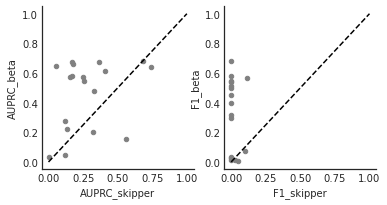

In [ ]:
f, ax = plt.subplots(1,2, figsize = (6,3))
data = stat_skipper.merge(stat, left_on = ['rep', 'ctrl'], right_on = ['rep', 'ctrl'],
                   suffixes = ('_skipper', '_beta'))
data.plot.scatter(x='AUPRC_skipper', y = 'AUPRC_beta', ax = ax[0], color = 'grey')

pr_cutoff_skipper.merge(pr_cutoff, left_index = True, right_index = True, suffixes = ('_skipper', '_beta')
                       ).plot.scatter(x='F1_skipper', y = 'F1_beta', ax = ax[1], color = 'grey')
_ = [a.plot([0,1], [0,1],  color = 'black',linestyle='dashed') for a in ax.flatten()]
sns.despine()
plt.savefig(figdir/'F1compare_SLNPsingleplex.pdf')

In [ ]:
data.loc[data['AUPRC_skipper']>data['AUPRC_beta']]

,rep,ctrl,AUPRC_skipper,AUPRC_beta
2,K562_SLBP_rep2,ABC_K562_summed,0.323437,0.203606
3,K562_SLBP_rep1,ABC_K562_summed,0.558915,0.157525
10,K562_SLBP_rep2,oligoCLIP_ctrlSpike_rep2,0.739660,0.642931
16,K562_SLBP_rep2,oligoCLIP_ctrlSpike_rep1,0.119010,0.046242


Text(0.5, 0.98, 'Using skipper')

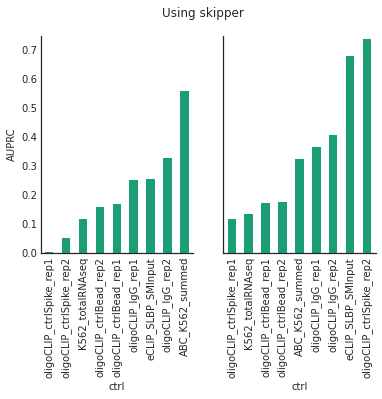

In [ ]:
f, ax = plt.subplots(1,2, sharey = True)
stat_skipper.loc[stat_skipper['rep']=='K562_SLBP_rep1'].set_index('ctrl')['AUPRC'].sort_values().plot.bar(ax = ax[0])
stat_skipper.loc[stat_skipper['rep']=='K562_SLBP_rep2'].set_index('ctrl')['AUPRC'].sort_values().plot.bar(ax = ax[1])
ax[0].set_ylabel('AUPRC')
ax[0].set_ylim(0, 0.75)
sns.despine()
plt.suptitle('Using skipper')

Text(0, 0.5, '% enriched is true histone(skipper)')

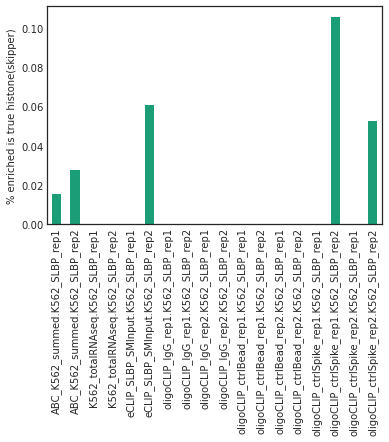

In [ ]:
(skipper_cnts.loc[True, True]/(skipper_cnts.loc[True, True]+skipper_cnts.loc[True, False])).sort_index().plot.bar()
plt.ylabel('% enriched is true histone(skipper)')

Text(0, 0.5, '% true histone captured(skipper)')

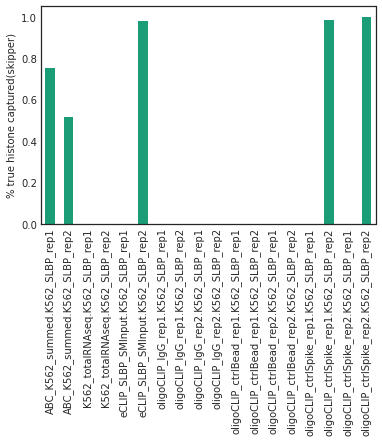

In [ ]:
(skipper_cnts.loc[True, True]/(skipper_cnts.loc[True, True]+skipper_cnts.loc[False, True])).sort_index().plot.bar()
plt.ylabel('% true histone captured(skipper)')

Text(0, 0.5, '# true histone sites captured(skipper)')

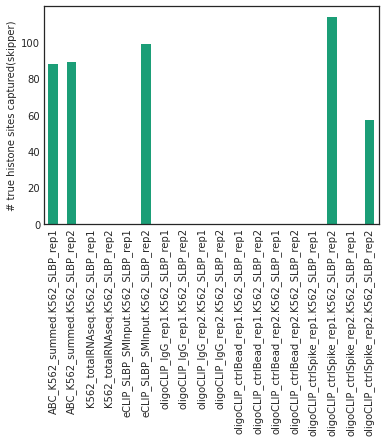

In [ ]:
skipper_cnts.loc[True, True].sort_index().plot.bar()
plt.ylabel('# true histone sites captured(skipper)')

In [ ]:
skipper_cnts.loc[True, True].sort_index()

ABC_K562_summed.K562_SLBP_rep1              88.0
ABC_K562_summed.K562_SLBP_rep2              89.0
K562_totalRNAseq.K562_SLBP_rep1              0.0
K562_totalRNAseq.K562_SLBP_rep2              0.0
eCLIP_SLBP_SMInput.K562_SLBP_rep1            0.0
eCLIP_SLBP_SMInput.K562_SLBP_rep2           99.0
oligoCLIP_IgG_rep1.K562_SLBP_rep1            0.0
oligoCLIP_IgG_rep1.K562_SLBP_rep2            0.0
oligoCLIP_IgG_rep2.K562_SLBP_rep1            0.0
oligoCLIP_IgG_rep2.K562_SLBP_rep2            0.0
oligoCLIP_ctrlBead_rep1.K562_SLBP_rep1       0.0
oligoCLIP_ctrlBead_rep1.K562_SLBP_rep2       0.0
oligoCLIP_ctrlBead_rep2.K562_SLBP_rep1       0.0
oligoCLIP_ctrlBead_rep2.K562_SLBP_rep2       0.0
oligoCLIP_ctrlSpike_rep1.K562_SLBP_rep1      0.0
oligoCLIP_ctrlSpike_rep1.K562_SLBP_rep2    114.0
oligoCLIP_ctrlSpike_rep2.K562_SLBP_rep1      0.0
oligoCLIP_ctrlSpike_rep2.K562_SLBP_rep2     57.0
Name: (True, True), dtype: float64